### Naive Baiyes Implementation
#### CountVectorization-ngram-1,2 & 3
#### TF-IDF-ngram-1,2 & 3

In [1]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [4]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0


## PRE-PROCESSING

In [5]:
# Basic utilities
import os
import platform
import re

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
import contractions

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation and data splitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report, 
                             precision_score, recall_score)

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning models
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB


In [6]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [7]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [8]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project Code/Tweets.csv'
df = pd.read_csv(data_pth)
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [9]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
neutral     40.457043
positive    31.228849
negative    28.314108
Name: sentiment, dtype: float64


In [10]:
def check_missing_data(dataframe):
    """
    Check for missing data in the dataframe.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to inspect.
    
    Returns:
    - pd.Series: A series containing counts of missing data for each column.
    """
    return dataframe.isnull().sum()

# Display the number of missing values for each column
print("Missing Values:\n", check_missing_data(df))

# Remove rows with missing values
df.dropna(inplace=True)
print(f"Post Filtering Step-1: Total Rows - {len(df)}")

Missing Values:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
Post Filtering Step-1: Total Rows - 27480


In [11]:
def custom_handle_contractions(text):
    """
    Expand contractions in the provided text using a predefined contractions dictionary.
    This function handles contractions formed both with standard apostrophes and backticks.
    
    Args:
    - text (str): The input text containing contractions.
    
    Returns:
    - str: The input text with all recognized contractions expanded.
    
    """
    
    # Define a dictionary of contractions and their expanded forms
    contractions_dict = contractions.contractions_dict
    
    # Replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        # Handle both apostrophes and backticks
        text = text.replace(contraction, expansion)
        text = text.replace(contraction.replace("'", "`"), expansion)

    return text

# Applying it to the DataFrame
df['text'] = df['text'].apply(custom_handle_contractions)


In [12]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I would have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why could not they put them on ...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I have wondered about rake to. The client ha...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [13]:
def clean_text(text):
    """
    Clean the provided text by removing URLs, mentions, numbers, hashtags, non-ASCII characters, and converting to lowercase.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The cleaned text.
    """
    text = text.lower() 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text

df['cleaned_tweets'] = df['text'].apply(clean_text)


In [14]:
def retain_required_columns(df, required_columns):
    """
    Retains only the specified required columns in the DataFrame and drops all others.
    
    Args:
    - df (pd.DataFrame): The input DataFrame.
    - required_columns (list): List of column names to retain.
    
    Returns:
    - pd.DataFrame: DataFrame containing only the required columns.
    """
    
    # Check if required columns are present in the dataframe
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"The following required columns are not present in the DataFrame: {missing_columns}")
    
    return df[required_columns]


df = retain_required_columns(df, ['sentiment', 'cleaned_tweets'])

In [15]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [16]:
# Detect all duplicates based on the 'cleaned_text' column
duplicates_mask = df.duplicated(subset='cleaned_tweets', keep=False)

# Remove all rows with duplicate 'cleaned_text'
df = df[~duplicates_mask]

In [17]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [18]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11030
positive     8435
negative     7735
Name: sentiment, dtype: int64
neutral     40.551471
positive    31.011029
negative    28.437500
Name: sentiment, dtype: float64


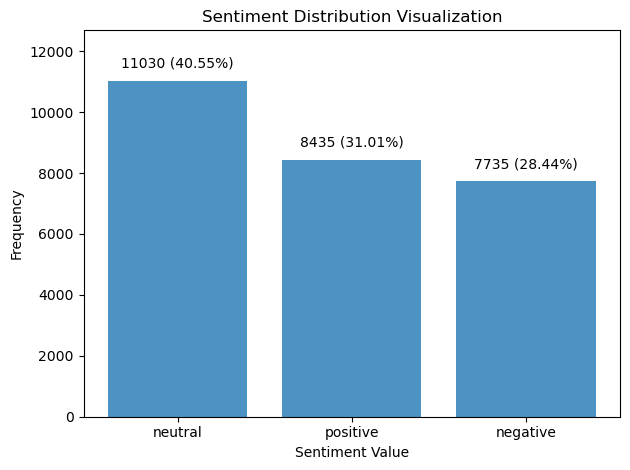

In [19]:
import matplotlib.pyplot as plt

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = df['sentiment'].value_counts()
sentiment_ratio = df['sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

Common Functions to be used:-

In [20]:
def display_tweets(true_labels, predicted_labels, input_tweets, num_samples=5):
    """
    Prints misclassified tweets given the true labels, predicted labels, and the input tweets.
    
    Parameters:
    - true_labels: Actual labels.
    - predicted_labels: Labels predicted by the classifier.
    - input_sentences: The raw input sentences for displaying misclassified instances.
    - num_samples: Number of misclassified samples to display for each sentiment.
    
    Returns:
    None.
    """
    true_labels_array = np.array(true_labels)
    misclassified_indices = np.where(true_labels_array != predicted_labels)[0]

    sentiment_list = np.unique(true_labels)
    
    for sentiment in sentiment_list:
        count = 0
        print(f"\nMisclassified tweets for {sentiment} sentiment:")
        
        for idx in misclassified_indices:
            if true_labels_array[idx] == sentiment:
                print(f"Actual: {true_labels_array[idx]}, Predicted: {predicted_labels[idx]}, Tweet: {input_tweets[idx]}")
                count += 1
            if count == num_samples:
                break
    print("\n")


In [21]:
'''def display_report(classifier_name, true_labels, predicted_labels, set_name):
    """
    Evaluate the performance of a classifier and display results including confusion matrix.
    
    Parameters:
    - classifier_name: Name of the classifier.
    - true_labels: Actual labels.
    - predicted_labels: Labels predicted by the classifier.
    - set_name: Dataset name (e.g., Validation, Test).
    - input_sentences: The raw input sentences for displaying misclassified instances.
    
    Returns:
    None.
    """
    # Display the name of the classifier and dataset
    print(f"Results for {classifier_name} on {set_name} Set:")
    
    # Display the classification report
    report = metrics.classification_report(true_labels, predicted_labels, target_names=np.unique(true_labels), digits=4)
    print(report)
    print("\n")
    
    # Compute and display confusion matrix
    cm = metrics.confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{classifier_name} Confusion Matrix ({set_name})")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()'''

'def display_report(classifier_name, true_labels, predicted_labels, set_name):\n    """\n    Evaluate the performance of a classifier and display results including confusion matrix.\n    \n    Parameters:\n    - classifier_name: Name of the classifier.\n    - true_labels: Actual labels.\n    - predicted_labels: Labels predicted by the classifier.\n    - set_name: Dataset name (e.g., Validation, Test).\n    - input_sentences: The raw input sentences for displaying misclassified instances.\n    \n    Returns:\n    None.\n    """\n    # Display the name of the classifier and dataset\n    print(f"Results for {classifier_name} on {set_name} Set:")\n    \n    # Display the classification report\n    report = metrics.classification_report(true_labels, predicted_labels, target_names=np.unique(true_labels), digits=4)\n    print(report)\n    print("\n")\n    \n    # Compute and display confusion matrix\n    cm = metrics.confusion_matrix(true_labels, predicted_labels)\n    sns.heatmap(cm, annot=T

In [22]:
def display_report(classifier_name, true_labels, predicted_labels, set_name):
    """
    Evaluate the performance of a classifier and display results including confusion matrix.
    
    Parameters:
    - classifier_name: Name of the classifier.
    - true_labels: Actual labels.
    - predicted_labels: Labels predicted by the classifier.
    - set_name: Dataset name (e.g., Validation, Test).
    - input_sentences: The raw input sentences for displaying misclassified instances.
    
    Returns:
    None.
    """
    # Display the name of the classifier and dataset
    print(f"Results for {classifier_name} on {set_name} Set:")
    
    # Display the classification report
    report = metrics.classification_report(true_labels, predicted_labels, target_names=np.unique(true_labels), digits=4)
    print(report)
    
    # Compute and display confusion matrix
    cm = metrics.confusion_matrix(true_labels, predicted_labels)
    
    specificities = []
    fprs = []
    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        
        specificities.append(specificity)
        fprs.append(fpr)

    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)
    weighted_avg_spec = sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values
    weighted_avg_fpr = sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values
    
    macro_avg_spec = sum(specificities) / 3
    macro_avg_fpr = sum(fprs) / 3
    
    labels = np.unique(true_labels)

    print("\nSpecificity per class:")
    for i in range(3):
        print(f"{labels[i]}: {specificities[i]:.4f}")
        
    print("\nFalse Positive Rate (FPR) per class:")
    for i in range(3):
        print(f"{labels[i]}: {fprs[i]:.4f}")
        
    print(f"\nWeighted average specificity: {weighted_avg_spec:.4f}")
    print(f"Weighted average FPR: {weighted_avg_fpr:.4f}")
    print(f"\nMacro average specificity: {macro_avg_spec:.4f}")
    print(f"Macro average FPR: {macro_avg_fpr:.4f}")

    # Display confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{classifier_name} Confusion Matrix ({set_name})")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [23]:
# Instantiating the tokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [24]:
param_grid = {
    "Multinomial NB": {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
        'fit_prior': [True, False]
    },
    "Bernoulli NB": {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
        'fit_prior': [True, False],
        'binarize': [0.0, 0.5, 1.0]
    },
    "Complement NB": {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
        'fit_prior': [True, False],
        'norm': [True, False]
    }
}

In [25]:
# Extracting the raw sentences using indices from previous splits
tweets = df['cleaned_tweets'].tolist()
train_indices, temp_indices = train_test_split(np.arange(len(tweets)), test_size=0.3, random_state=5)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=5)

tweets_train = [tweets[i] for i in train_indices]
tweets_val = [tweets[i] for i in val_indices]
tweets_test = [tweets[i] for i in test_indices]

#### CV = 1ngram + Naive Baiyes Implementation

In [26]:
# Initializing the CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer=token.tokenize, token_pattern=None)
# Transforming the data
text_counts = cv.fit_transform(df['cleaned_tweets'])

In [27]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_counts, df['sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [28]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [29]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 2.0
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7057    0.4830    0.5735      1147
     neutral     0.5793    0.7111    0.6385      1679
    positive     0.6840    0.6730    0.6785      1254

    accuracy                         0.6353      4080
   macro avg     0.6563    0.6224    0.6302      4080
weighted avg     0.6470    0.6353    0.6325      4080


Specificity per class:
negative: 0.8982
neutral: 0.6172
positive: 0.8176

False Positive Rate (FPR) per class:
negative: 0.1018
neutral: 0.3828
positive: 0.1824

Weighted average specificity: 0.7578
Weighted average FPR: 0.2422

Macro average specificity: 0.7777
Macro average FPR: 0.2223


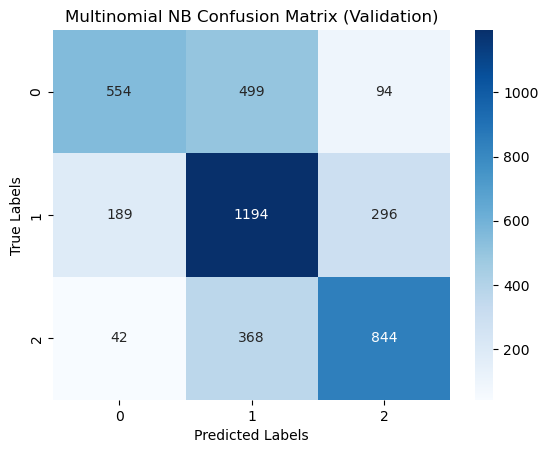

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7538    0.4925    0.5957      1194
     neutral     0.5664    0.7341    0.6394      1621
    positive     0.6981    0.6617    0.6794      1265

    accuracy                         0.6409      4080
   macro avg     0.6728    0.6294    0.6382      4080
weighted avg     0.6621    0.6409    0.6390      4080


Specificity per class:
negative: 0.9135
neutral: 0.6100
positive: 0.8308

False Positive Rate (FPR) per class:
negative: 0.0865
neutral: 0.3900
positive: 0.1692

Weighted average specificity: 0.7673
Weighted average FPR: 0.2327

Macro average specificity: 0.7848
Macro average FPR: 0.2152


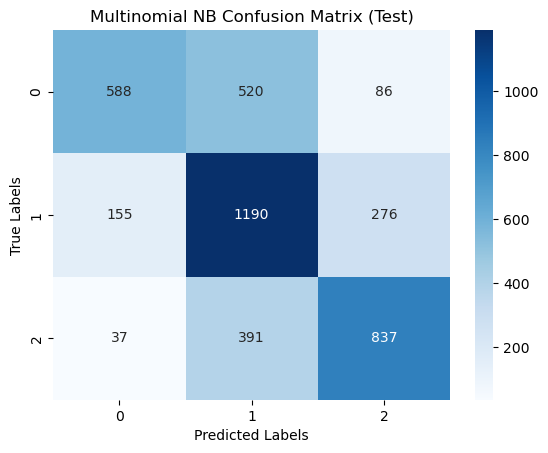

In [30]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [31]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: neutral, Tweet: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: positive, Tweet: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet:  when i tried to go to hers i got this message that page does not exist 
Actual: negative, Predicted: neutral, Tweet:  amhzz did u get an invite i miss u

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: positive, Tweet:  absolutely
Actual: neutral, Predicted: negative, Tweet:  michelleeeeeeeeeeeemybelleeeeeeeeeeeeeeeeee snif snif
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie ama

In [32]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [33]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.5
binarize: 0.0
fit_prior: False


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.6329    0.5667    0.5980      1147
     neutral     0.5966    0.6492    0.6218      1679
    positive     0.6843    0.6691    0.6766      1254

    accuracy                         0.6321      4080
   macro avg     0.6380    0.6283    0.6321      4080
weighted avg     0.6338    0.6321    0.6319      4080


Specificity per class:
negative: 0.8365
neutral: 0.6689
positive: 0.8181

False Positive Rate (FPR) per class:
negative: 0.1635
neutral: 0.3311
positive: 0.1819

Weighted average specificity: 0.7619
Weighted average FPR: 0.2381

Macro average specificity: 0.7745
Macro average FPR: 0.2255


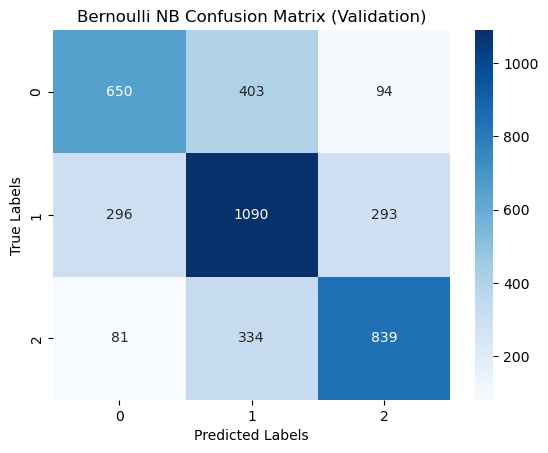

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.6584    0.5762    0.6146      1194
     neutral     0.5693    0.6539    0.6087      1621
    positive     0.6939    0.6435    0.6678      1265

    accuracy                         0.6279      4080
   macro avg     0.6405    0.6245    0.6303      4080
weighted avg     0.6340    0.6279    0.6287      4080


Specificity per class:
negative: 0.8400
neutral: 0.6519
positive: 0.8296

False Positive Rate (FPR) per class:
negative: 0.1600
neutral: 0.3481
positive: 0.1704

Weighted average specificity: 0.7620
Weighted average FPR: 0.2380

Macro average specificity: 0.7738
Macro average FPR: 0.2262


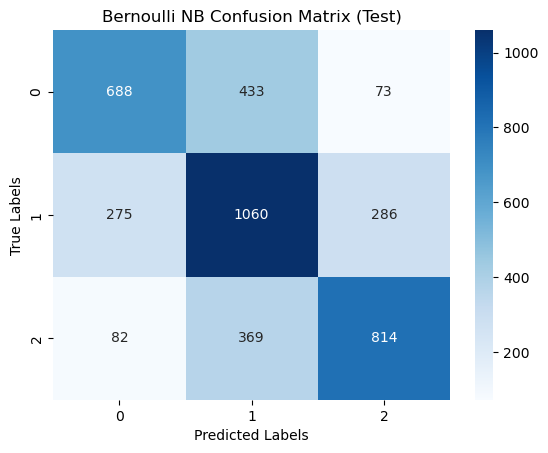

In [34]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [35]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet:  when i tried to go to hers i got this message that page does not exist 
Actual: negative, Predicted: neutral, Tweet:  amhzz did u get an invite i miss u
Actual: negative, Predicted: positive, Tweet:  so sadsorry to hear that  she was a sweet dog

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie amazingmy phone died yesterdayand oster has alltel  i miss you
Actual: neutral, Predicted: negative, Tweet:  no problem unfortunately i think it was just something i had to sort out on my own
Actual: neutral, Predicted: nega

In [36]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [37]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 2.0
fit_prior: True
norm: True


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.6381    0.6042    0.6207      1147
     neutral     0.6303    0.5301    0.5759      1679
    positive     0.6214    0.7839    0.6932      1254

    accuracy                         0.6289      4080
   macro avg     0.6299    0.6394    0.6299      4080
weighted avg     0.6298    0.6289    0.6245      4080


Specificity per class:
negative: 0.8266
neutral: 0.7625
positive: 0.7255

False Positive Rate (FPR) per class:
negative: 0.1734
neutral: 0.2375
positive: 0.2745

Weighted average specificity: 0.7691
Weighted average FPR: 0.2309

Macro average specificity: 0.7715
Macro average FPR: 0.2285


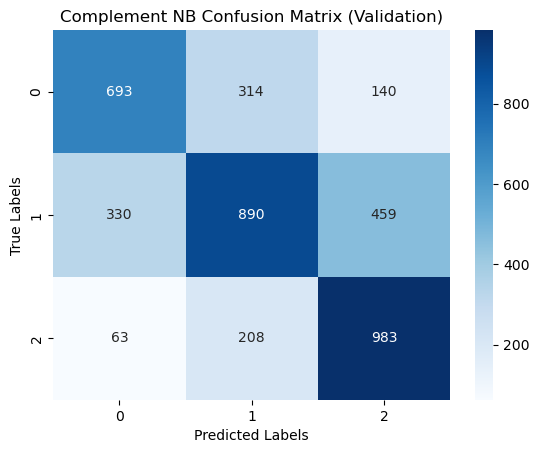

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.6568    0.5963    0.6251      1194
     neutral     0.6039    0.5398    0.5700      1621
    positive     0.6283    0.7684    0.6913      1265

    accuracy                         0.6272      4080
   macro avg     0.6297    0.6348    0.6288      4080
weighted avg     0.6269    0.6272    0.6238      4080


Specificity per class:
negative: 0.8324
neutral: 0.7458
positive: 0.7340

False Positive Rate (FPR) per class:
negative: 0.1676
neutral: 0.2542
positive: 0.2660

Weighted average specificity: 0.7675
Weighted average FPR: 0.2325

Macro average specificity: 0.7707
Macro average FPR: 0.2293


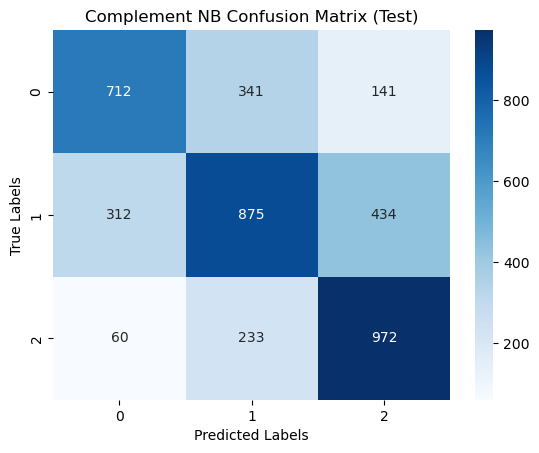

In [38]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [39]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: neutral, Tweet: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: positive, Tweet: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet:  when i tried to go to hers i got this message that page does not exist 
Actual: negative, Predicted: neutral, Tweet:  amhzz did u get an invite i miss u

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: positive, Tweet:  absolutely
Actual: neutral, Predicted: negative, Tweet:  michelleeeeeeeeeeeemybelleeeeeeeeeeeeeeeeee snif snif
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie ama

#### CV = 2ngram + Naive Baiyes Implementation

In [40]:
# Initializing the CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(2,2), tokenizer=token.tokenize, token_pattern=None)

# Transforming the data
text_counts = cv.fit_transform(df['cleaned_tweets'])

In [41]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_counts, df['sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [42]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [43]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 2.0
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.5049    0.2711    0.3528      1147
     neutral     0.4846    0.7504    0.5889      1679
    positive     0.6296    0.4338    0.5137      1254

    accuracy                         0.5184      4080
   macro avg     0.5397    0.4851    0.4851      4080
weighted avg     0.5349    0.5184    0.4994      4080


Specificity per class:
negative: 0.8554
neutral: 0.3895
positive: 0.8308

False Positive Rate (FPR) per class:
negative: 0.1446
neutral: 0.6105
positive: 0.1692

Weighted average specificity: 0.6561
Weighted average FPR: 0.3439

Macro average specificity: 0.6919
Macro average FPR: 0.3081


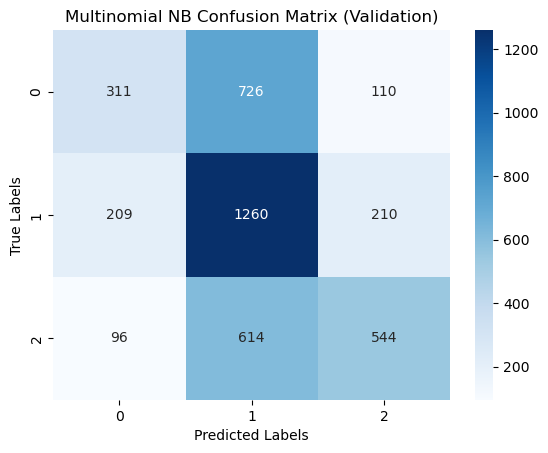

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.5498    0.2956    0.3845      1194
     neutral     0.4728    0.7563    0.5819      1621
    positive     0.6296    0.4206    0.5043      1265

    accuracy                         0.5174      4080
   macro avg     0.5507    0.4908    0.4902      4080
weighted avg     0.5440    0.5174    0.5001      4080


Specificity per class:
negative: 0.8588
neutral: 0.3930
positive: 0.8346

False Positive Rate (FPR) per class:
negative: 0.1412
neutral: 0.6070
positive: 0.1654

Weighted average specificity: 0.6662
Weighted average FPR: 0.3338

Macro average specificity: 0.6955
Macro average FPR: 0.3045


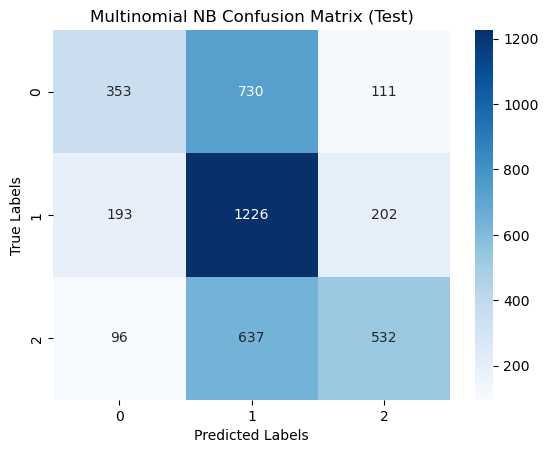

In [44]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [45]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: positive, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: ugh my internet was down
Actual: negative, Predicted: neutral, Tweet: miss the newest version on glade on debian
Actual: negative, Predicted: neutral, Tweet: i want to karaoke  insteadi get to go to work  lameness

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie amazingmy phone died yesterdayand oster has alltel  i miss you
Actual: neutral, Predicted: negative, Tweet:  aww poor caity  l add people n they will add you
Actual: neutral, Predicted: negative, Tweet: at dads watching some mtv and am going on sims in a 

In [46]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [47]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.1
binarize: 0.0
fit_prior: True


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.4100    0.4769    0.4410      1147
     neutral     0.5172    0.5742    0.5442      1679
    positive     0.6145    0.4322    0.5075      1254

    accuracy                         0.5032      4080
   macro avg     0.5139    0.4944    0.4975      4080
weighted avg     0.5170    0.5032    0.5039      4080


Specificity per class:
negative: 0.6568
neutral: 0.5475
positive: 0.8163

False Positive Rate (FPR) per class:
negative: 0.3432
neutral: 0.4525
positive: 0.1837

Weighted average specificity: 0.6608
Weighted average FPR: 0.3392

Macro average specificity: 0.6735
Macro average FPR: 0.3265


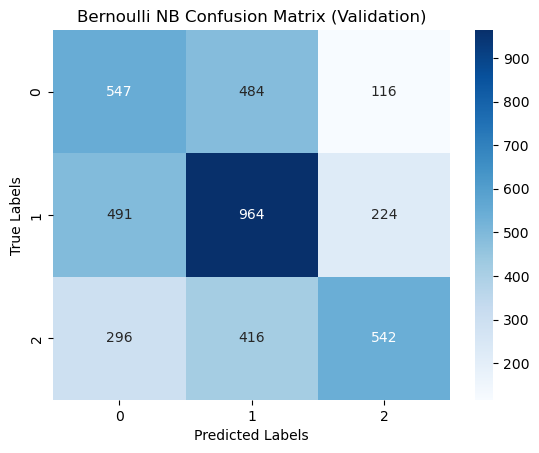

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.4325    0.4883    0.4587      1194
     neutral     0.4880    0.5645    0.5235      1621
    positive     0.6196    0.4198    0.5005      1265

    accuracy                         0.4973      4080
   macro avg     0.5134    0.4908    0.4942      4080
weighted avg     0.5126    0.4973    0.4974      4080


Specificity per class:
negative: 0.6540
neutral: 0.5371
positive: 0.8213

False Positive Rate (FPR) per class:
negative: 0.3460
neutral: 0.4629
positive: 0.1787

Weighted average specificity: 0.6594
Weighted average FPR: 0.3406

Macro average specificity: 0.6708
Macro average FPR: 0.3292


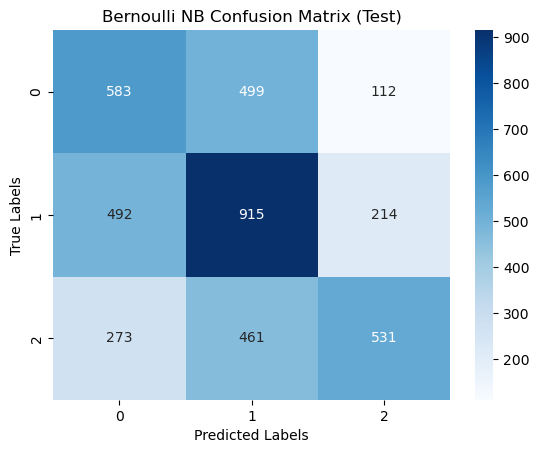

In [48]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [49]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: ugh my internet was down
Actual: negative, Predicted: neutral, Tweet: miss the newest version on glade on debian
Actual: negative, Predicted: neutral, Tweet: i want to karaoke  insteadi get to go to work  lameness
Actual: negative, Predicted: neutral, Tweet: i hate the fact that i am  hours away from you tonight and tomorrow we will be  miles apart  i wish you were here 

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie amazingmy phone died yesterdayand oster has alltel  i miss you
Actual: neutral, Predicted: negative, Tweet: is hittin the ole dusty trail w miss morgan
Actual: neutral, Predicted: negative, Tweet:  or a mexican wrestler they year capes too

In [50]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [51]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 2.0
fit_prior: True
norm: True


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.3425    0.7289    0.4660      1147
     neutral     0.5016    0.1912    0.2768      1679
    positive     0.6036    0.4809    0.5353      1254

    accuracy                         0.4314      4080
   macro avg     0.4825    0.4670    0.4260      4080
weighted avg     0.4882    0.4314    0.4095      4080


Specificity per class:
negative: 0.3654
neutral: 0.8185
positive: 0.7450

False Positive Rate (FPR) per class:
negative: 0.6346
neutral: 0.1815
positive: 0.2550

Weighted average specificity: 0.6685
Weighted average FPR: 0.3315

Macro average specificity: 0.6430
Macro average FPR: 0.3570


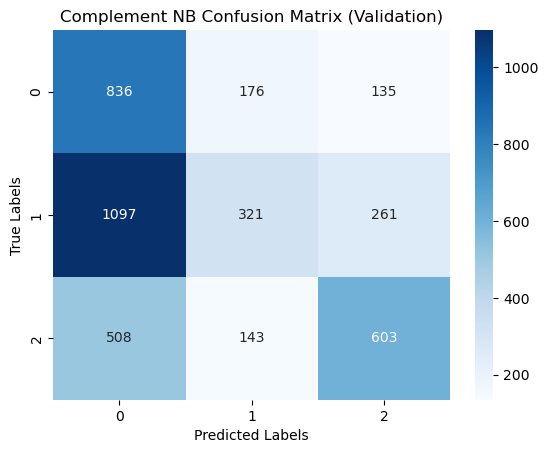

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.3625    0.7462    0.4880      1194
     neutral     0.4816    0.1937    0.2763      1621
    positive     0.5969    0.4577    0.5181      1265

    accuracy                         0.4373      4080
   macro avg     0.4803    0.4659    0.4275      4080
weighted avg     0.4825    0.4373    0.4132      4080


Specificity per class:
negative: 0.3630
neutral: 0.8131
positive: 0.7550

False Positive Rate (FPR) per class:
negative: 0.6370
neutral: 0.1869
positive: 0.2450

Weighted average specificity: 0.6634
Weighted average FPR: 0.3366

Macro average specificity: 0.6437
Macro average FPR: 0.3563


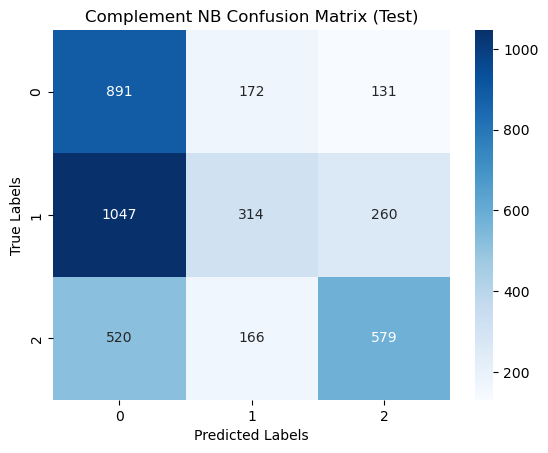

In [52]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [53]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: positive, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: well on a normal day i would already be done with workunfortunately this is not a normal day which means i will be in the office till late
Actual: negative, Predicted: positive, Tweet:  i did not read the details so that may be it sara jayne is a kids show so it cannot be that exciting
Actual: negative, Predicted: positive, Tweet: thinkin twitter is really quite borin

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet:  absolutely
Actual: neutral, Predicted: negative, Tweet: _aries me and that person have something in common then lol jk
Actual: neutral, Pred

#### CV = 3ngram + Naive Baiyes Implementation

In [54]:
# Initializing the CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(3,3), tokenizer=token.tokenize, token_pattern=None)

# Transforming the data
text_counts = cv.fit_transform(df['cleaned_tweets'])

In [55]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_counts, df['sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [56]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [57]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 2.0
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.4578    0.0331    0.0618      1147
     neutral     0.4262    0.9672    0.5917      1679
    positive     0.8075    0.1204    0.2096      1254

    accuracy                         0.4444      4080
   macro avg     0.5639    0.3736    0.2877      4080
weighted avg     0.5523    0.4444    0.3253      4080


Specificity per class:
negative: 0.9753
neutral: 0.0796
positive: 0.9788

False Positive Rate (FPR) per class:
negative: 0.0247
neutral: 0.9204
positive: 0.0212

Weighted average specificity: 0.6078
Weighted average FPR: 0.3922

Macro average specificity: 0.6779
Macro average FPR: 0.3221


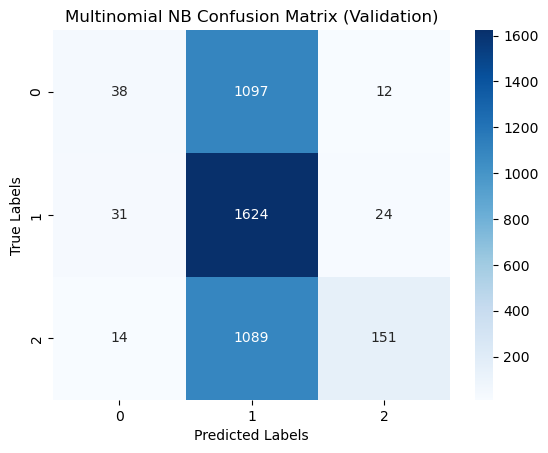

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.5657    0.0469    0.0866      1194
     neutral     0.4101    0.9667    0.5759      1621
    positive     0.7438    0.0941    0.1670      1265

    accuracy                         0.4270      4080
   macro avg     0.5732    0.3692    0.2765      4080
weighted avg     0.5591    0.4270    0.3059      4080


Specificity per class:
negative: 0.9751
neutral: 0.0720
positive: 0.9754

False Positive Rate (FPR) per class:
negative: 0.0249
neutral: 0.9280
positive: 0.0246

Weighted average specificity: 0.6164
Weighted average FPR: 0.3836

Macro average specificity: 0.6742
Macro average FPR: 0.3258


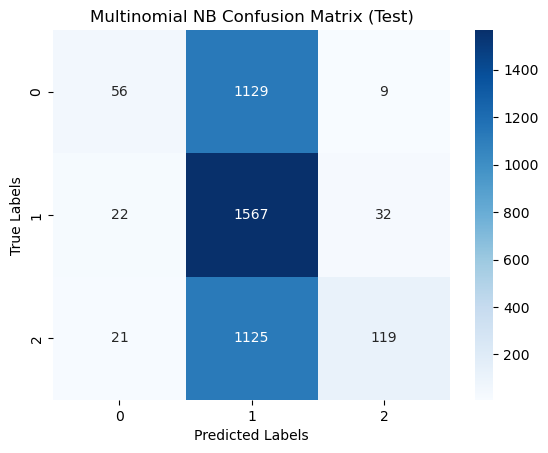

In [58]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [59]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: neutral, Tweet: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: neutral, Tweet: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: bloody servers are down at work for at least  hours want to go home now

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet: just for fun jessica alba weekly twitter follower count   this is starting to look like a movement  
Actual: neutral, Predicted: positive, Twe

In [60]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [61]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.5
binarize: 0.0
fit_prior: True


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.3333    0.0331    0.0603      1147
     neutral     0.4224    0.9684    0.5883      1679
    positive     0.8547    0.0797    0.1459      1254

    accuracy                         0.4324      4080
   macro avg     0.5368    0.3604    0.2648      4080
weighted avg     0.5302    0.4324    0.3039      4080


Specificity per class:
negative: 0.9578
neutral: 0.0584
positive: 0.9899

False Positive Rate (FPR) per class:
negative: 0.0422
neutral: 0.9416
positive: 0.0101

Weighted average specificity: 0.5976
Weighted average FPR: 0.4024

Macro average specificity: 0.6687
Macro average FPR: 0.3313


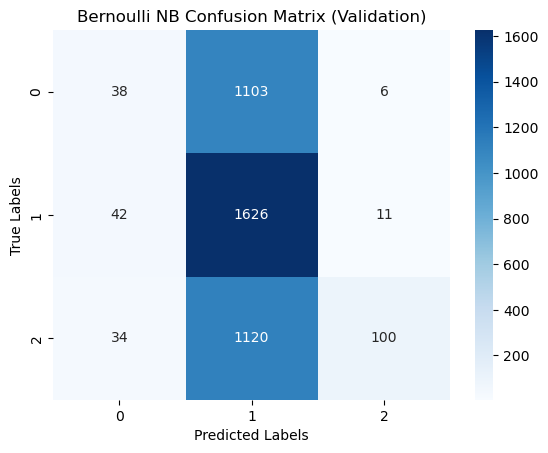

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.3588    0.0394    0.0709      1194
     neutral     0.4048    0.9630    0.5700      1621
    positive     0.7742    0.0569    0.1060      1265

    accuracy                         0.4118      4080
   macro avg     0.5126    0.3531    0.2490      4080
weighted avg     0.5059    0.4118    0.2801      4080


Specificity per class:
negative: 0.9511
neutral: 0.0493
positive: 0.9871

False Positive Rate (FPR) per class:
negative: 0.0489
neutral: 0.9507
positive: 0.0129

Weighted average specificity: 0.6040
Weighted average FPR: 0.3960

Macro average specificity: 0.6625
Macro average FPR: 0.3375


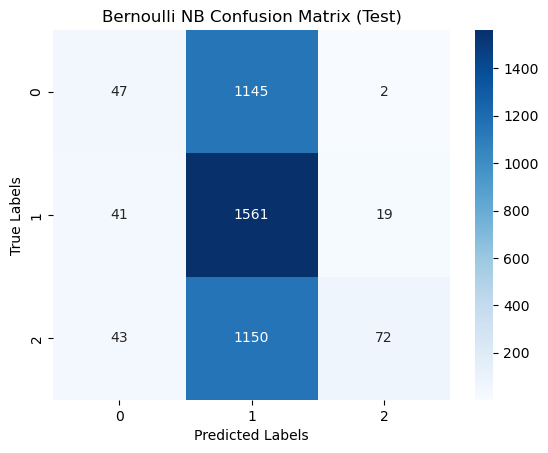

In [62]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [63]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: neutral, Tweet: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: bloody servers are down at work for at least  hours want to go home now
Actual: negative, Predicted: neutral, Tweet: ugh my internet was down

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet:  workin ur crazy sched has to be tiringits got to  be hard being famous  but jus kno u have bazillionz of fans supprtin u
Actual: neutral, Predicted: positive, Tweet: done with the fkn exam n just bought the mother

In [64]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [65]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 0.5
fit_prior: True
norm: True


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.2931    0.9730    0.4505      1147
     neutral     0.4714    0.0197    0.0377      1679
    positive     0.7635    0.1236    0.2128      1254

    accuracy                         0.3196      4080
   macro avg     0.5094    0.3721    0.2337      4080
weighted avg     0.5111    0.3196    0.2076      4080


Specificity per class:
negative: 0.0653
neutral: 0.9717
positive: 0.9599

False Positive Rate (FPR) per class:
negative: 0.9347
neutral: 0.0283
positive: 0.0401

Weighted average specificity: 0.7133
Weighted average FPR: 0.2867

Macro average specificity: 0.6656
Macro average FPR: 0.3344


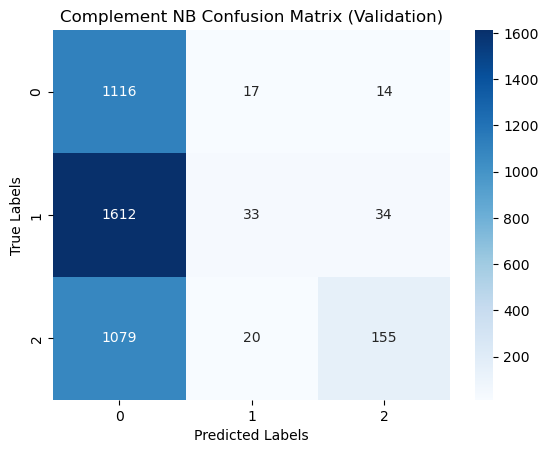

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.3038    0.9724    0.4630      1194
     neutral     0.4384    0.0197    0.0378      1621
    positive     0.7151    0.1051    0.1833      1265

    accuracy                         0.3250      4080
   macro avg     0.4858    0.3657    0.2280      4080
weighted avg     0.4848    0.3250    0.2073      4080


Specificity per class:
negative: 0.0584
neutral: 0.9693
positive: 0.9575

False Positive Rate (FPR) per class:
negative: 0.9416
neutral: 0.0307
positive: 0.0425

Weighted average specificity: 0.6991
Weighted average FPR: 0.3009

Macro average specificity: 0.6617
Macro average FPR: 0.3383


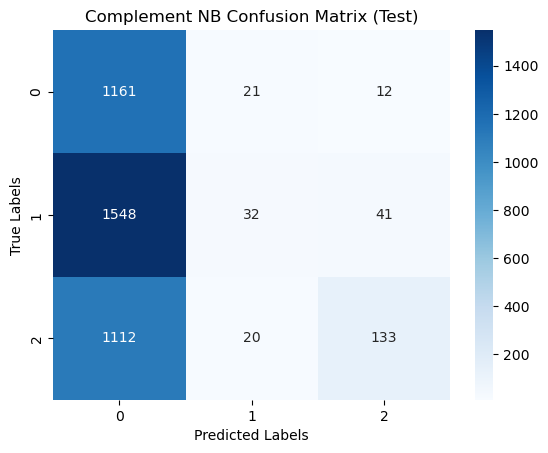

In [66]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [67]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: positive, Tweet: thinkin twitter is really quite borin
Actual: negative, Predicted: neutral, Tweet:   if you do not want to come then do not come jeeeeez
Actual: negative, Predicted: positive, Tweet: not looking forward to the upcoming weekmy better half will be gone all that time its truly gonna suck big time
Actual: negative, Predicted: positive, Tweet: such a busy day today banbury fair fashion show tonight and move into my apartment tomorrow i have no started packing yet

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet:  absolutely
Actual: neutral, Predicted: negative, Tweet: _aries me and that person have something in common then lol jk
Actual: neutral, Predicted: negative, Tweet:  my 

#### TF-IDF ngram=1

In [68]:
# Initialize the TfidfVectorizer with the same settings as CountVectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1),  tokenizer=token.tokenize, token_pattern=None)

# Transforming the data using the TfidfVectorizer
text_tfidf = tfidf.fit_transform(df['cleaned_tweets'])

In [69]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_tfidf, df['sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [70]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [71]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 2.0
fit_prior: False


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.6466    0.5344    0.5852      1147
     neutral     0.5799    0.6313    0.6045      1679
    positive     0.6664    0.6930    0.6794      1254

    accuracy                         0.6230      4080
   macro avg     0.6310    0.6196    0.6230      4080
weighted avg     0.6252    0.6230    0.6221      4080


Specificity per class:
negative: 0.8520
neutral: 0.6587
positive: 0.7936

False Positive Rate (FPR) per class:
negative: 0.1480
neutral: 0.3413
positive: 0.2064

Weighted average specificity: 0.7545
Weighted average FPR: 0.2455

Macro average specificity: 0.7681
Macro average FPR: 0.2319


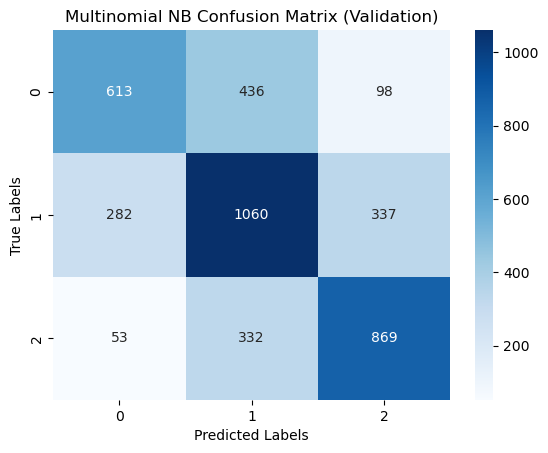

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.6691    0.5335    0.5937      1194
     neutral     0.5619    0.6385    0.5977      1621
    positive     0.6750    0.6862    0.6805      1265

    accuracy                         0.6225      4080
   macro avg     0.6353    0.6194    0.6240      4080
weighted avg     0.6283    0.6225    0.6222      4080


Specificity per class:
negative: 0.8580
neutral: 0.6510
positive: 0.8000

False Positive Rate (FPR) per class:
negative: 0.1420
neutral: 0.3490
positive: 0.2000

Weighted average specificity: 0.7578
Weighted average FPR: 0.2422

Macro average specificity: 0.7696
Macro average FPR: 0.2304


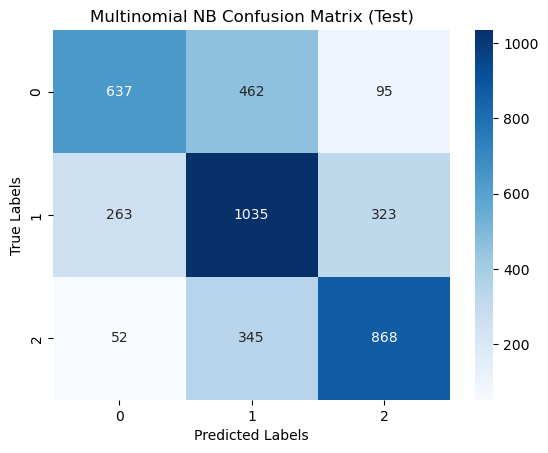

In [72]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [73]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: neutral, Tweet: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: positive, Tweet: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet:  when i tried to go to hers i got this message that page does not exist 
Actual: negative, Predicted: neutral, Tweet:  amhzz did u get an invite i miss u

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: positive, Tweet:  absolutely
Actual: neutral, Predicted: negative, Tweet:  michelleeeeeeeeeeeemybelleeeeeeeeeeeeeeeeee snif snif
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie ama

In [74]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [75]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.5
binarize: 0.0
fit_prior: False


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.6329    0.5667    0.5980      1147
     neutral     0.5966    0.6492    0.6218      1679
    positive     0.6843    0.6691    0.6766      1254

    accuracy                         0.6321      4080
   macro avg     0.6380    0.6283    0.6321      4080
weighted avg     0.6338    0.6321    0.6319      4080


Specificity per class:
negative: 0.8365
neutral: 0.6689
positive: 0.8181

False Positive Rate (FPR) per class:
negative: 0.1635
neutral: 0.3311
positive: 0.1819

Weighted average specificity: 0.7619
Weighted average FPR: 0.2381

Macro average specificity: 0.7745
Macro average FPR: 0.2255


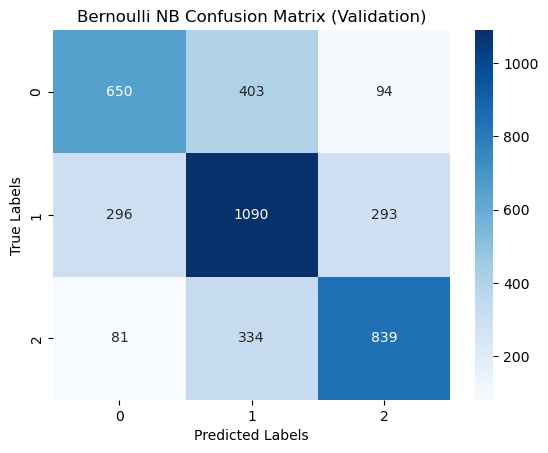

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.6584    0.5762    0.6146      1194
     neutral     0.5693    0.6539    0.6087      1621
    positive     0.6939    0.6435    0.6678      1265

    accuracy                         0.6279      4080
   macro avg     0.6405    0.6245    0.6303      4080
weighted avg     0.6340    0.6279    0.6287      4080


Specificity per class:
negative: 0.8400
neutral: 0.6519
positive: 0.8296

False Positive Rate (FPR) per class:
negative: 0.1600
neutral: 0.3481
positive: 0.1704

Weighted average specificity: 0.7620
Weighted average FPR: 0.2380

Macro average specificity: 0.7738
Macro average FPR: 0.2262


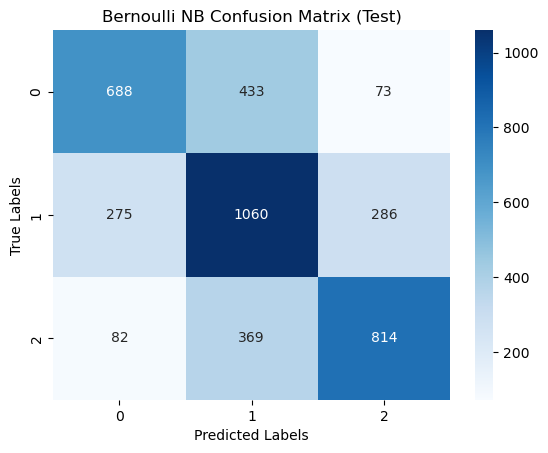

In [76]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [77]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet:  when i tried to go to hers i got this message that page does not exist 
Actual: negative, Predicted: neutral, Tweet:  amhzz did u get an invite i miss u
Actual: negative, Predicted: positive, Tweet:  so sadsorry to hear that  she was a sweet dog

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie amazingmy phone died yesterdayand oster has alltel  i miss you
Actual: neutral, Predicted: negative, Tweet:  no problem unfortunately i think it was just something i had to sort out on my own
Actual: neutral, Predicted: nega

In [78]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [79]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 2.0
fit_prior: True
norm: True


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.6495    0.5815    0.6136      1147
     neutral     0.6174    0.5843    0.6004      1679
    positive     0.6421    0.7496    0.6917      1254

    accuracy                         0.6343      4080
   macro avg     0.6363    0.6385    0.6352      4080
weighted avg     0.6340    0.6343    0.6322      4080


Specificity per class:
negative: 0.8422
neutral: 0.7255
positive: 0.7587

False Positive Rate (FPR) per class:
negative: 0.1578
neutral: 0.2745
positive: 0.2413

Weighted average specificity: 0.7685
Weighted average FPR: 0.2315

Macro average specificity: 0.7755
Macro average FPR: 0.2245


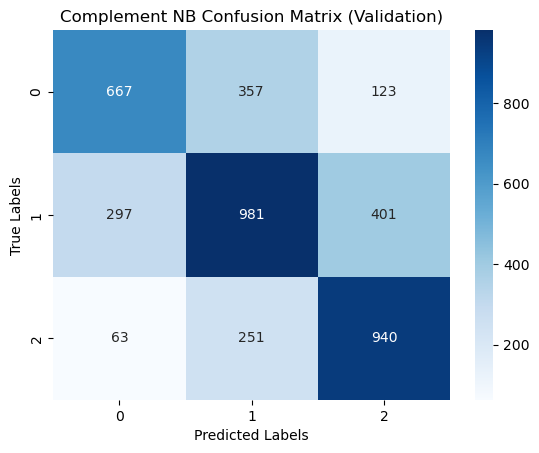

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.6792    0.5745    0.6225      1194
     neutral     0.5927    0.6033    0.5980      1621
    positive     0.6570    0.7375    0.6950      1265

    accuracy                         0.6365      4080
   macro avg     0.6430    0.6385    0.6385      4080
weighted avg     0.6380    0.6365    0.6352      4080


Specificity per class:
negative: 0.8550
neutral: 0.7067
positive: 0.7736

False Positive Rate (FPR) per class:
negative: 0.1450
neutral: 0.2933
positive: 0.2264

Weighted average specificity: 0.7708
Weighted average FPR: 0.2292

Macro average specificity: 0.7784
Macro average FPR: 0.2216


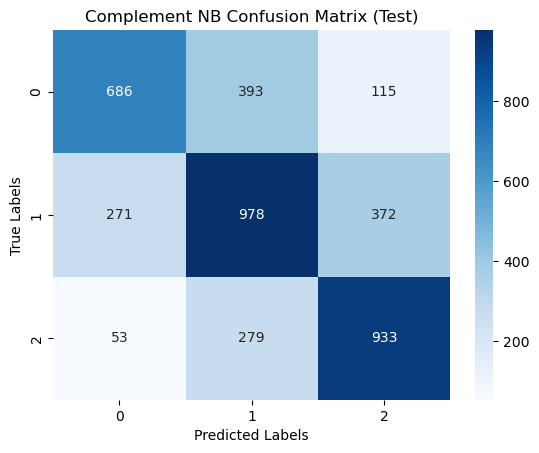

In [80]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [81]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: neutral, Tweet: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: positive, Tweet: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet:  when i tried to go to hers i got this message that page does not exist 
Actual: negative, Predicted: neutral, Tweet:  amhzz did u get an invite i miss u

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: positive, Tweet:  absolutely
Actual: neutral, Predicted: negative, Tweet:  michelleeeeeeeeeeeemybelleeeeeeeeeeeeeeeeee snif snif
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie ama

TF-IDF ngram=2

In [82]:
# Initialize the TfidfVectorizer with the same settings as CountVectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 2), tokenizer=token.tokenize, token_pattern=None)

# Transforming the data using the TfidfVectorizer
text_tfidf = tfidf.fit_transform(df['cleaned_tweets'])

In [83]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_tfidf, df['sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [84]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [85]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 0.1
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.4340    0.4071    0.4202      1147
     neutral     0.5083    0.6409    0.5669      1679
    positive     0.6223    0.4402    0.5156      1254

    accuracy                         0.5135      4080
   macro avg     0.5215    0.4961    0.5009      4080
weighted avg     0.5224    0.5135    0.5099      4080


Specificity per class:
negative: 0.7278
neutral: 0.4947
positive: 0.8216

False Positive Rate (FPR) per class:
negative: 0.2722
neutral: 0.5053
positive: 0.1784

Weighted average specificity: 0.6607
Weighted average FPR: 0.3393

Macro average specificity: 0.6813
Macro average FPR: 0.3187


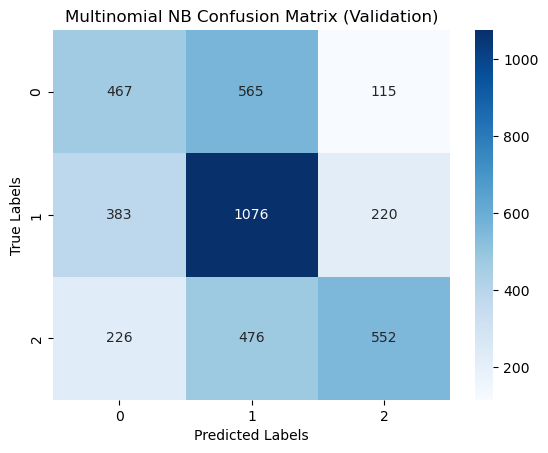

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.4687    0.4263    0.4465      1194
     neutral     0.4855    0.6403    0.5523      1621
    positive     0.6203    0.4198    0.5007      1265

    accuracy                         0.5093      4080
   macro avg     0.5248    0.4955    0.4998      4080
weighted avg     0.5224    0.5093    0.5053      4080


Specificity per class:
negative: 0.7311
neutral: 0.4860
positive: 0.8264

False Positive Rate (FPR) per class:
negative: 0.2689
neutral: 0.5140
positive: 0.1736

Weighted average specificity: 0.6633
Weighted average FPR: 0.3367

Macro average specificity: 0.6812
Macro average FPR: 0.3188


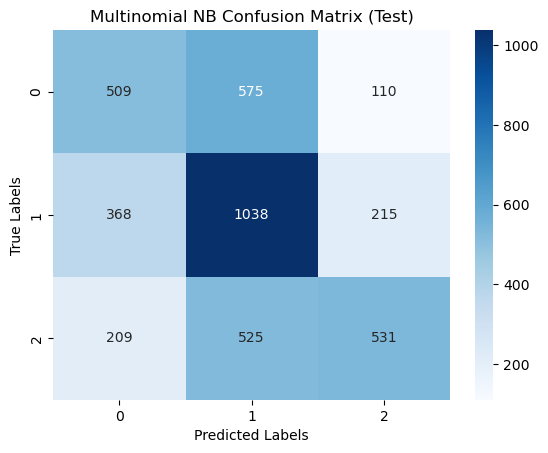

In [86]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [87]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: positive, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: bloody servers are down at work for at least  hours want to go home now
Actual: negative, Predicted: neutral, Tweet: ugh my internet was down
Actual: negative, Predicted: neutral, Tweet: miss the newest version on glade on debian

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie amazingmy phone died yesterdayand oster has alltel  i miss you
Actual: neutral, Predicted: negative, Tweet: is hittin the ole dusty trail w miss morgan
Actual: neutral, Predicted: negative, Tweet:  aww poor caity  l add people n they will 

In [88]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [89]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.1
binarize: 0.0
fit_prior: True


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.4100    0.4769    0.4410      1147
     neutral     0.5172    0.5742    0.5442      1679
    positive     0.6145    0.4322    0.5075      1254

    accuracy                         0.5032      4080
   macro avg     0.5139    0.4944    0.4975      4080
weighted avg     0.5170    0.5032    0.5039      4080


Specificity per class:
negative: 0.6568
neutral: 0.5475
positive: 0.8163

False Positive Rate (FPR) per class:
negative: 0.3432
neutral: 0.4525
positive: 0.1837

Weighted average specificity: 0.6608
Weighted average FPR: 0.3392

Macro average specificity: 0.6735
Macro average FPR: 0.3265


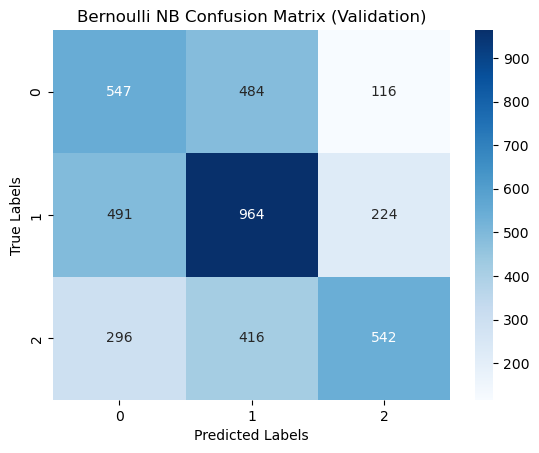

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.4325    0.4883    0.4587      1194
     neutral     0.4880    0.5645    0.5235      1621
    positive     0.6196    0.4198    0.5005      1265

    accuracy                         0.4973      4080
   macro avg     0.5134    0.4908    0.4942      4080
weighted avg     0.5126    0.4973    0.4974      4080


Specificity per class:
negative: 0.6540
neutral: 0.5371
positive: 0.8213

False Positive Rate (FPR) per class:
negative: 0.3460
neutral: 0.4629
positive: 0.1787

Weighted average specificity: 0.6594
Weighted average FPR: 0.3406

Macro average specificity: 0.6708
Macro average FPR: 0.3292


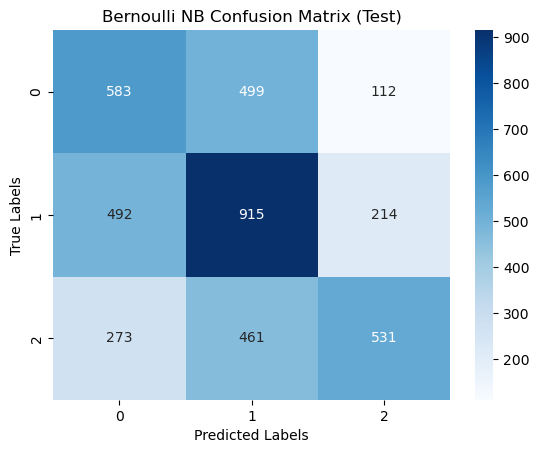

In [90]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [91]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: ugh my internet was down
Actual: negative, Predicted: neutral, Tweet: miss the newest version on glade on debian
Actual: negative, Predicted: neutral, Tweet: i want to karaoke  insteadi get to go to work  lameness
Actual: negative, Predicted: neutral, Tweet: i hate the fact that i am  hours away from you tonight and tomorrow we will be  miles apart  i wish you were here 

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet: omgdid i just see a tweet from miss bonnie amazingmy phone died yesterdayand oster has alltel  i miss you
Actual: neutral, Predicted: negative, Tweet: is hittin the ole dusty trail w miss morgan
Actual: neutral, Predicted: negative, Tweet:  or a mexican wrestler they year capes too

In [92]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [93]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 2.0
fit_prior: True
norm: False


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.3389    0.7219    0.4613      1147
     neutral     0.4858    0.1942    0.2774      1679
    positive     0.6046    0.4657    0.5261      1254

    accuracy                         0.4260      4080
   macro avg     0.4764    0.4606    0.4216      4080
weighted avg     0.4810    0.4260    0.4056      4080


Specificity per class:
negative: 0.3604
neutral: 0.8036
positive: 0.7513

False Positive Rate (FPR) per class:
negative: 0.6396
neutral: 0.1964
positive: 0.2487

Weighted average specificity: 0.6629
Weighted average FPR: 0.3371

Macro average specificity: 0.6384
Macro average FPR: 0.3616


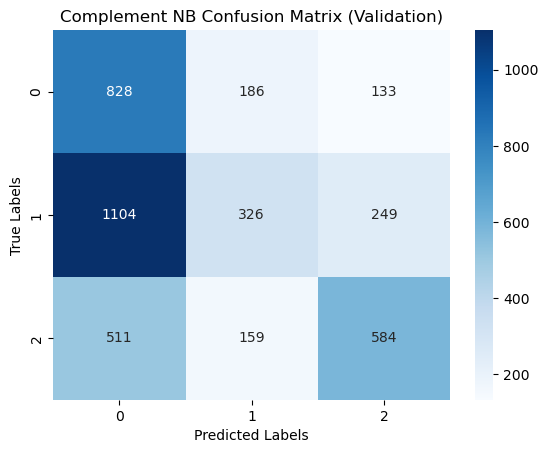

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.3638    0.7471    0.4893      1194
     neutral     0.4934    0.2067    0.2913      1621
    positive     0.6080    0.4561    0.5212      1265

    accuracy                         0.4422      4080
   macro avg     0.4884    0.4700    0.4339      4080
weighted avg     0.4910    0.4422    0.4205      4080


Specificity per class:
negative: 0.3689
neutral: 0.8103
positive: 0.7674

False Positive Rate (FPR) per class:
negative: 0.6311
neutral: 0.1897
positive: 0.2326

Weighted average specificity: 0.6678
Weighted average FPR: 0.3322

Macro average specificity: 0.6488
Macro average FPR: 0.3512


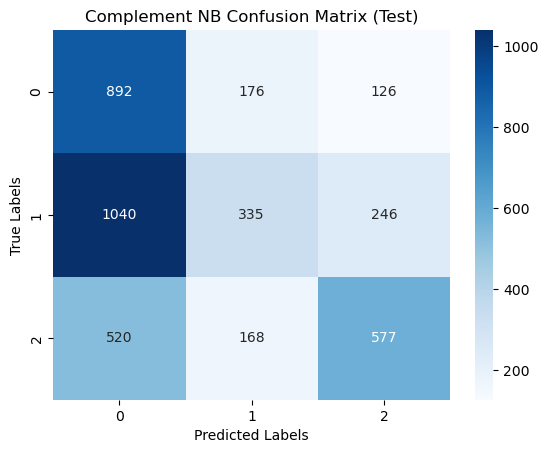

In [94]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [95]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: positive, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: well on a normal day i would already be done with workunfortunately this is not a normal day which means i will be in the office till late
Actual: negative, Predicted: positive, Tweet:  i did not read the details so that may be it sara jayne is a kids show so it cannot be that exciting
Actual: negative, Predicted: positive, Tweet: thinkin twitter is really quite borin

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet:  absolutely
Actual: neutral, Predicted: negative, Tweet: _aries me and that person have something in common then lol jk
Actual: neutral, Pred

TF-IDF ngram=3

In [96]:
# Initialize the TfidfVectorizer with the same settings as CountVectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(3, 3),  tokenizer=token.tokenize, token_pattern=None)

# Transforming the data using the TfidfVectorizer
text_tfidf = tfidf.fit_transform(df['cleaned_tweets'])

In [97]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_tfidf, df['sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [98]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [99]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 0.5
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.5385    0.0183    0.0354      1147
     neutral     0.4252    0.9833    0.5937      1679
    positive     0.8291    0.1045    0.1856      1254

    accuracy                         0.4419      4080
   macro avg     0.5976    0.3687    0.2715      4080
weighted avg     0.5812    0.4419    0.3113      4080


Specificity per class:
negative: 0.9900
neutral: 0.0638
positive: 0.9841

False Positive Rate (FPR) per class:
negative: 0.0100
neutral: 0.9362
positive: 0.0159

Weighted average specificity: 0.6070
Weighted average FPR: 0.3930

Macro average specificity: 0.6793
Macro average FPR: 0.3207


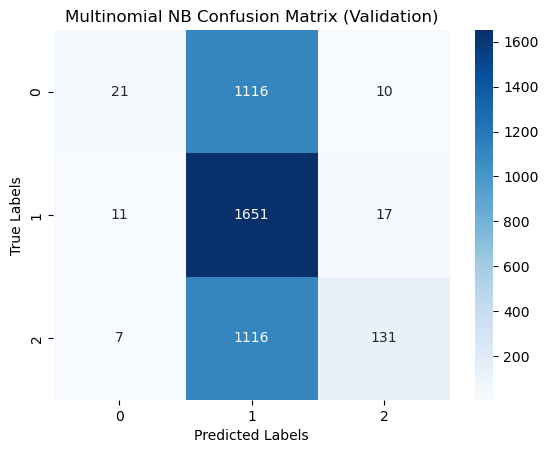

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7436    0.0243    0.0470      1194
     neutral     0.4066    0.9821    0.5751      1621
    positive     0.7857    0.0783    0.1423      1265

    accuracy                         0.4216      4080
   macro avg     0.6453    0.3616    0.2548      4080
weighted avg     0.6228    0.4216    0.2864      4080


Specificity per class:
negative: 0.9941
neutral: 0.0522
positive: 0.9836

False Positive Rate (FPR) per class:
negative: 0.0059
neutral: 0.9478
positive: 0.0164

Weighted average specificity: 0.6166
Weighted average FPR: 0.3834

Macro average specificity: 0.6767
Macro average FPR: 0.3233


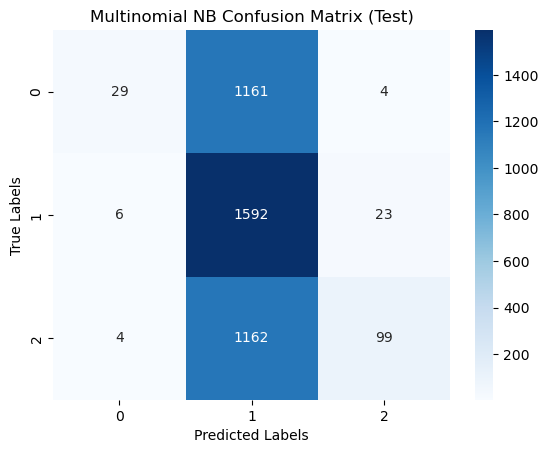

In [100]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [101]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: neutral, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: neutral, Tweet: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: neutral, Tweet: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: bloody servers are down at work for at least  hours want to go home now

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: positive, Tweet:  make sure you come back and comment again
Actual: neutral, Predicted: positive, Tweet: soo sad my mcmcbuddy thinks i look like i could have a 

In [102]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [103]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.5
binarize: 0.0
fit_prior: True


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.3333    0.0331    0.0603      1147
     neutral     0.4224    0.9684    0.5883      1679
    positive     0.8547    0.0797    0.1459      1254

    accuracy                         0.4324      4080
   macro avg     0.5368    0.3604    0.2648      4080
weighted avg     0.5302    0.4324    0.3039      4080


Specificity per class:
negative: 0.9578
neutral: 0.0584
positive: 0.9899

False Positive Rate (FPR) per class:
negative: 0.0422
neutral: 0.9416
positive: 0.0101

Weighted average specificity: 0.5976
Weighted average FPR: 0.4024

Macro average specificity: 0.6687
Macro average FPR: 0.3313


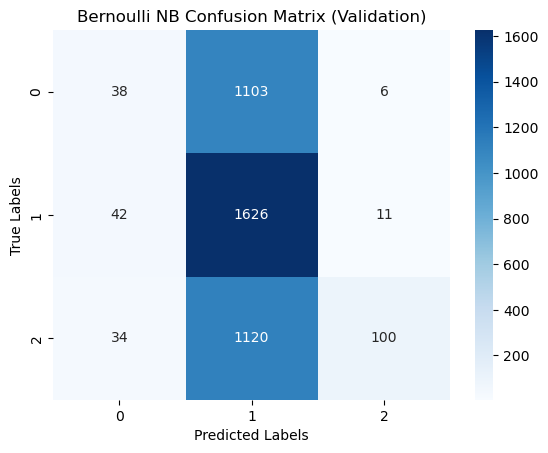

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.3588    0.0394    0.0709      1194
     neutral     0.4048    0.9630    0.5700      1621
    positive     0.7742    0.0569    0.1060      1265

    accuracy                         0.4118      4080
   macro avg     0.5126    0.3531    0.2490      4080
weighted avg     0.5059    0.4118    0.2801      4080


Specificity per class:
negative: 0.9511
neutral: 0.0493
positive: 0.9871

False Positive Rate (FPR) per class:
negative: 0.0489
neutral: 0.9507
positive: 0.0129

Weighted average specificity: 0.6040
Weighted average FPR: 0.3960

Macro average specificity: 0.6625
Macro average FPR: 0.3375


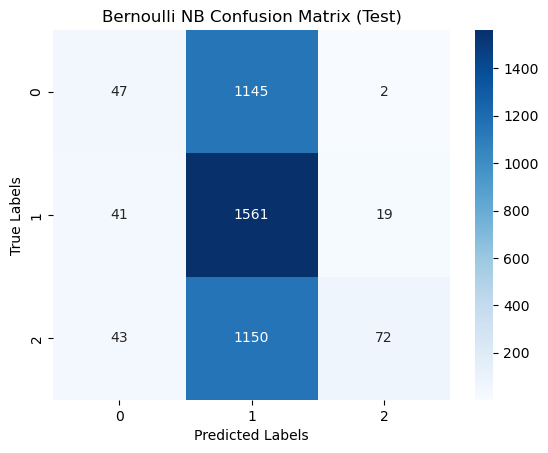

In [104]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [105]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: neutral, Tweet: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: neutral, Tweet: just got off the phone with lainey the love of my life     now im taken a 
Actual: negative, Predicted: neutral, Tweet: bloody servers are down at work for at least  hours want to go home now
Actual: negative, Predicted: neutral, Tweet: ugh my internet was down

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet:  workin ur crazy sched has to be tiringits got to  be hard being famous  but jus kno u have bazillionz of fans supprtin u
Actual: neutral, Predicted: positive, Tweet: done with the fkn exam n just bought the mother

In [106]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [107]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 0.5
fit_prior: True
norm: False


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.2934    0.9738    0.4509      1147
     neutral     0.5128    0.0238    0.0455      1679
    positive     0.7846    0.1220    0.2112      1254

    accuracy                         0.3211      4080
   macro avg     0.5303    0.3732    0.2359      4080
weighted avg     0.5347    0.3211    0.2104      4080


Specificity per class:
negative: 0.0669
neutral: 0.9709
positive: 0.9650

False Positive Rate (FPR) per class:
negative: 0.9331
neutral: 0.0291
positive: 0.0350

Weighted average specificity: 0.7150
Weighted average FPR: 0.2850

Macro average specificity: 0.6676
Macro average FPR: 0.3324


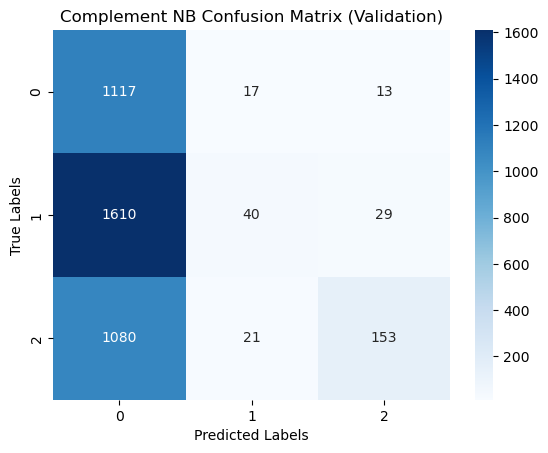

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.3036    0.9724    0.4627      1194
     neutral     0.4535    0.0241    0.0457      1621
    positive     0.7353    0.0988    0.1742      1265

    accuracy                         0.3248      4080
   macro avg     0.4975    0.3651    0.2275      4080
weighted avg     0.4970    0.3248    0.2076      4080


Specificity per class:
negative: 0.0580
neutral: 0.9647
positive: 0.9639

False Positive Rate (FPR) per class:
negative: 0.9420
neutral: 0.0353
positive: 0.0361

Weighted average specificity: 0.6991
Weighted average FPR: 0.3009

Macro average specificity: 0.6622
Macro average FPR: 0.3378


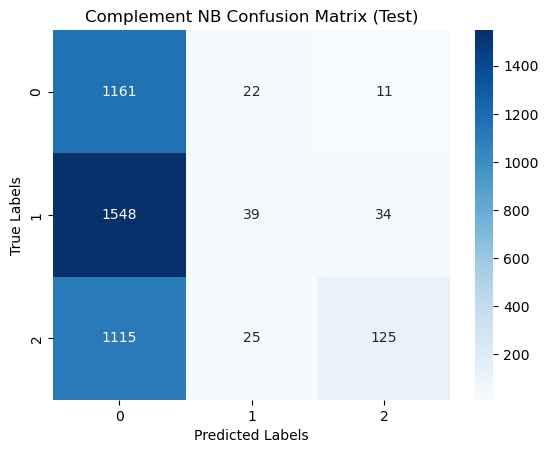

In [108]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [109]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_tweets(Y_val, predicted_val, tweets_val)

# For test set
print("Misclassified Samples for Test Set:")
display_tweets(Y_test, predicted_test, tweets_test)


Misclassified Samples for Validation Set:

Misclassified tweets for negative sentiment:
Actual: negative, Predicted: positive, Tweet: just got finished watching marley and me and i cried like a  babyi am missing my beast like crazy
Actual: negative, Predicted: positive, Tweet: thinkin twitter is really quite borin
Actual: negative, Predicted: neutral, Tweet:   if you do not want to come then do not come jeeeeez
Actual: negative, Predicted: positive, Tweet: not looking forward to the upcoming weekmy better half will be gone all that time its truly gonna suck big time
Actual: negative, Predicted: positive, Tweet: such a busy day today banbury fair fashion show tonight and move into my apartment tomorrow i have no started packing yet

Misclassified tweets for neutral sentiment:
Actual: neutral, Predicted: negative, Tweet:  absolutely
Actual: neutral, Predicted: negative, Tweet: _aries me and that person have something in common then lol jk
Actual: neutral, Predicted: negative, Tweet:  my 